In [310]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from onix.analysis.fitter import Fitter
import numpy as np

import matplotlib.pyplot as plt

In [388]:
def gaussian(f, f_0, a, sigma, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c

def get_gaussian_fit(detunings, voltages):    
    fitter = Fitter(gaussian)
    fitter.set_data(detunings, voltages)
    fitter.fit()
    
    return fitter

In [2]:
def data_groups(data, headers):
    chasm_repeats = headers["params"]["detect"]["chasm_repeats"]
    antihole_repeats = headers["params"]["detect"]["antihole_repeats"]
    if "rf_repeats" in headers["params"]["detect"]:
        rf_repeats = headers["params"]["detect"]["rf_repeats"]
    else:
        rf_repeats = 0
    total_detect_repeats = chasm_repeats + antihole_repeats + rf_repeats
    experiment_repeats = headers["params"]["repeats"]

    chasm_avg = []
    antihole_avg = []
    rf_avg = []
    for kk in range(len(data["transmissions_avg"])):
        remainder = kk % total_detect_repeats
        if remainder < chasm_repeats:
            chasm_avg.append(data["transmissions_avg"][kk])
        elif remainder < chasm_repeats + antihole_repeats:
            antihole_avg.append(data["transmissions_avg"][kk])
        else:
            rf_avg.append(data["transmissions_avg"][kk])
    chasm_avg = np.array(chasm_avg)
    antihole_avg = np.array(antihole_avg)
    rf_avg = np.array(rf_avg)

    if "monitors_avg" in data:
        monitor_chasm_avg = []
        monitor_antihole_avg = []
        monitor_rf_avg = []
        for kk in range(len(data["monitors_avg"])):
            remainder = kk % total_detect_repeats
            if remainder < chasm_repeats:
                monitor_chasm_avg.append(data["monitors_avg"][kk])
            elif remainder < chasm_repeats + antihole_repeats:
                monitor_antihole_avg.append(data["monitors_avg"][kk])
            else:
                monitor_rf_avg.append(data["monitors_avg"][kk])
        monitor_chasm_avg = np.array(monitor_chasm_avg)
        monitor_antihole_avg = np.array(monitor_antihole_avg)
        monitor_rf_avg = np.array(monitor_rf_avg)
        return ((chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg))
    
    return (chasm_avg, antihole_avg, rf_avg)

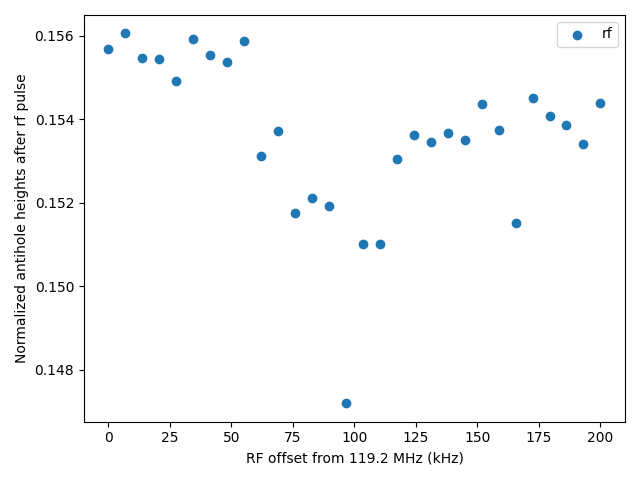

In [306]:
rf_offsets = []
antihole_heights = []
rf_antihole_heights = []
rf_averages = []
for kk in range(3545, 3575):  #3343, 3373
    data, headers = get_experiment_data(kk)
    rf_offset = headers["params"]["rf"]["offset"].to("kHz").magnitude
    rf_offsets.append(rf_offset)
    (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
    detunings_MHz = headers["detunings"].to("MHz").magnitude
    antihole_heights.append(np.max(np.average(antihole_avg, axis=0)) - np.min(np.average(antihole_avg, axis=0)))
    rf_antihole_heights.append(np.max(np.average(rf_avg, axis=0)) - np.min(np.average(rf_avg, axis=0)))
    rf_averages.append(np.average(rf_avg))

fig, ax = plt.subplots()
#ax.scatter(rf_offsets, chasm_antihole_power_ratios)
#ax.set_ylabel("Power ratio between chasm and antihole probes")
ax.set_xlabel("RF offset from 119.2 MHz (kHz)")
ax.set_ylabel("Normalized antihole heights after rf pulse")
ax.scatter(rf_offsets, np.array(rf_antihole_heights) / np.array(rf_averages), label="rf")
#ax.scatter(rf_offsets, np.array(rf_antihole_heights), label="rf")
ax.legend()
plt.tight_layout()
plt.show()

In [300]:
data, headers = get_experiment_data(3556)

In [301]:
(chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

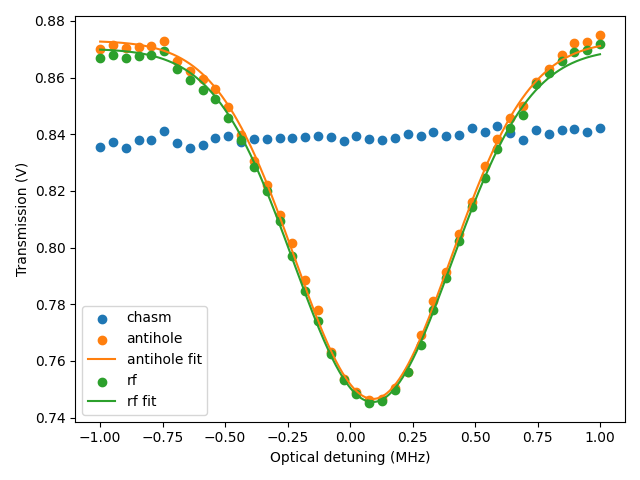

In [395]:
plt_monitor = False

fig, ax = plt.subplots()
ax.scatter(detunings_MHz, np.average(chasm_avg, axis=0), label="chasm", color="C0")
ax.scatter(detunings_MHz, np.average(antihole_avg, axis=0), label="antihole", color="C1")

antihole_fit = get_gaussian_fit(detunings_MHz, np.average(antihole_avg, axis=0))
xaxis = np.linspace(min(detunings_MHz), max(detunings_MHz), 1000)
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    ax.scatter(detunings_MHz, np.average(rf_avg, axis=0), label="rf", color="C2")
    #ax.scatter(detunings_MHz, np.average(rf_avg, axis=0) / np.average(antihole_avg, axis=0), label="rf / antihole")

    rf_fit = get_gaussian_fit(detunings_MHz, np.average(rf_avg, axis=0))
    ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.legend()
if plt_monitor:
    ax1 = ax.twinx()
    ax1.scatter(detunings_MHz, np.average(monitor_chasm_avg, axis=0), label="monitor_chasm", marker=".")
    ax1.scatter(detunings_MHz, np.average(monitor_antihole_avg, axis=0), label="monitor_antihole", marker=".")
    if "rf_repeats" in headers["params"]["detect"]:
        ax1.scatter(detunings_MHz, np.average(monitor_rf_avg, axis=0), label="monitor_rf", marker=".")
    ax1.set_ylabel("Monitor (V)")
    plt.legend()
plt.tight_layout()
plt.show()